# Mandatory assignment 4 by Abdullah Karagøz

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

## Introduction

In this assignment we'll just experiment with Convolutional Neural Network with CIFAR-10 dataset.

I'll do the following as assignment asks:
1. Download the CIFAR-10 dataset and preprocess it.
2. Print size of the train and test datasets, shape of the images and different classes of the dataset.
3. Visualize 2 or 3 random images and their class labels from the training and testing datasets, respectively.
4. Split the training dataset into training and validation sets.
5. Use data loaders for the three datasets.
6. Implementing convolutional neural network class to classify CIFAR-10 data using nn.Module.
7. Change the runtime type to a GPU to speed up the training.Then, plot the training and validation losses with respect to the epoch numbers.
8. Test CNN using the test data. Report the accuracy of your CNN classification overall and per-class.
9. Make a new CNN class that is a copy of original CNN. Then add a convolutional layer to the new network architecture. Train the new network, the same way as the first network (same hyperparameters, optimizer and number of epochs ...) and compare the accuracy results (overall and perclass) with the old network.

### Goal
The goal is to see how CNN works and how one more convolution layer affects.

### Method
We will build a CNN model using PyTorch, train and test the model using CIFAR-10 image set. Then make a new model with one more convolution layer to the model, train and test it again. And compare the results. We will use mini-batch SDG (batch size = 32) with Momentum (Momentum rate 0.4) in optimization. We'll measure results with prediction accuracy and Cross Entropy Loss.

### Assignment outline

1. Download the data from CIFAR-10 using torchvision.datasets
2. Data exploration (size, content, label classes)
3. Visualize data instances (show some images from the set)
4. Split the original training dataset between training and validation
5. Preparing dataloaders for training, validation and test sets.
6. Building first CNN model class.
7. Training the dataset
> 7.1 Functions for training (with validation) and testing routine
>
> 7.2 Training the dataset with the model using a GPU, plot the training curve
8. Report the test set performance
9. Second CNN model
> 9.1 Build the second CNN model with an additional convolution stage, training the dataset with the model. 
>
> 9.2 Compare the results from the first CNN model.
>
> 9.3 Results







## 1. Download the CIFAR-10 data set

In [ ]:
# This is to make it more reproductible, taken from https://pytorch.org/docs/stable/notes/randomness.html
seed = 3

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# The function and generator will be used when generating dataloaders as parameters
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

In [ ]:
# Downloading data, normalization using values from https://github.com/kuangliu/pytorch-cifar/issues/19
transform_data = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                     ])

train = datasets.CIFAR10(root='cifar10/', download=True, train=True, transform=transform_data)
test = datasets.CIFAR10(root='cifar10/', download=True, train=False, transform=transform_data)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10/
Files already downloaded and verified


## 2. Data exploration (size, content, label classes)

In [ ]:
# Printing length and classes
print("Length of training set:", len(train))
print("Length of testing set:", len(test))
image, label = next(iter(train))
print("Shape of an image: ", image.shape)

classes_dict = {c: l for c,l in zip(train.classes, range(10))}

print("\nThe classes of the dataset are: ", classes_dict)

print("\n\nFirst 10 labels: ")
j = 10
for image, label in train:
  j -= 1
  print(" {} ({}), ".format(label, train.classes[label]), end="")
  if j == 0:
    break

Length of training set: 50000
Length of testing set: 10000
Shape of an image:  torch.Size([3, 32, 32])

The classes of the dataset are:  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


First 10 labels: 
 6 (frog),  9 (truck),  9 (truck),  4 (deer),  1 (automobile),  1 (automobile),  2 (bird),  7 (horse),  8 (ship),  3 (cat), 

## 3. Visualize data instances (show some images from the set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


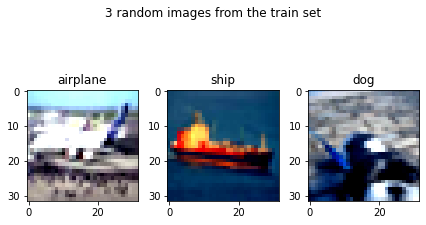

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


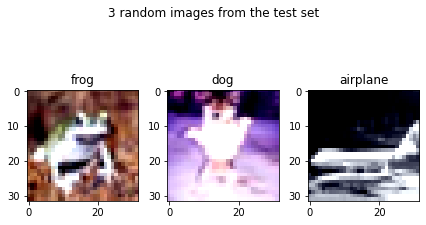

In [ ]:
# Showing some random images from the training set and testing set
indexes = np.random.randint(0, 50000, 3)

#This function is taken and partly edited from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar
def imshow(img, lbl, ax):
    img2 = img / 2 + 0.5     # unnormalize
    npimg = img2.numpy()
    ax.set_title(train.classes[lbl])
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

fig, axes = plt.subplots(1, 3)
for i in range(3):
  image, label = train[indexes[i]]
  imshow(make_grid(image), label, axes[i])
fig.tight_layout(pad=1.0)
plt.suptitle("3 random images from the train set")
plt.show()

indexes = np.random.randint(0, 10000, 3)
fig, axes = plt.subplots(1, 3)
for i in range(3):
  image, label = test[indexes[i]]
  imshow(make_grid(image), label, axes[i])
fig.tight_layout(pad=1.0)
plt.suptitle("3 random images from the test set")
plt.show()

## 4. Split the original training dataset between training and validation

In [ ]:
# Split rate, 20% of training data will be used as validation. That is to make validation size equal to testing size. (0.2*50,000 = 10,000)
train_valid_split = 0.2


# Splitting the data
train_set, valid_set = torch.utils.data.random_split(train, [int(round((1-train_valid_split)*len(train))), int(round(train_valid_split*len(train)))])

## 5. Preparing dataloaders for training, validation and test sets

We use batch size 32. Too low batch may cause more volatile learning with higher variance in classification accuracy, but too high batch may slow down the learning process. So I use a batch size that's equal to 32. I tried with 16 too, but the it performed better with 32. I didn't experiemnt much with batch size. I wanted to speed things up so I choose 32 and didn't experiment with higher batch sizes.

In [ ]:
batch_size = 32

# Lodaing data with batches
# We set pin_memory=True to allocate samples in page-locked memory to speed up
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## 6. Building the first CNN model class

Here I almost copied what was shown in the lectures. I added one more convolution layer because convolution layers are used to build features out of features. In theory it works like this: first convolution layer decets features like edges. Second detects features like circles by using features detected in the first convolution layer. Thrid layer detects features like faces, legs etc. also more high-level features are detected.

The pictures are small and difficult to classify. So I thought one more convolution layer would make the model predict better and it did in my experience.

I didn't made much tuning because the training process is slow and it takes time. But I still tried a couple of things.

Dropout rate prevents over-learning. I tried dropout of 0.2, 0.3 and 0.6. I got better results when drop-out rate is 0.6.

I have experimented with different learning rates and found 0.02 to be good enough. I set the Momentum rate to 0.9 because this is what's usually set (from lecture notes). I experimented with Momentum rate 0, 0.4, 0.5, and 0.6 too. But I got best results when I set it to 0.5 or 0.6. So I set it to 0.5. I didn't try other values.

I started with small epoch like 20. The dataset is big, it takes a lot of time to run the code. And in the plots it seems after 20 iterations the mean CEL on validation doesn't change much. After tuning other parameters like dropout and Momentum I saw that CEL is still moving down after epoch 20. Thus I increased the epoch to 30 and 40. I observed it works better with 30 (at least not worst than 40, so no need to iterate too many times).



In [ ]:
# Class for the first CNN model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.6)
    self.fc1 = nn.Linear(64*4*4, 256)
    self.output = nn.Linear(256, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)
    return self.output(x)


NameError: ignored

In [ ]:
# Setting the hyper parameters
epochs = 30
lr = 0.02
decay_rate = 0.5

# Use the NN model with GPU
cnn = CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn.to(device)

# Set loss criterion and optimization method
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=decay_rate)

The settings and hyper-paremeters we have used are:
* Epoch = 30
* Learning rate = 0.02
* Batch size: 32
* Dataset size: 60,000
* Dataset: CIFAR-10
* Split rate between training, validation and testing: 4:1:1
* Optimizer: mini-Batch SDG with Momentum, Momentum rate: 0.5
* Loss: Cross Entropy Loss
* First model: 3 convolution layers with pooling using ReLU and dropout
* Second model: 4 convolution layers with pooling using ReLU and dropout
* Dropout rate: 0.6

## 7. Training the dataset

### 7.1 Functions for training (with validation) and testing routine

In [ ]:
# Functions for training with validation routine and testing routine. We define them first to make the code more clean later.

#Training with validation
def training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, device):
  train_results = list()
  valid_results = list()
  for ep in range(num_epochs):
    running_loss = 0
    valid_loss = 0
    model.train() # Set model into training mode
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
      # all previos gradient descents, instead of the gradient descents on the current batch.
      optimizer.zero_grad() 
      output = model(images) # prediction / output from the model
      loss = criterion(output, labels)  # We calculate the loss here
      loss.backward() # Computes the derivative of the loss using backpropagation.
      optimizer.step() # We update the weights
      running_loss += loss.item() # Sum the loss here
    else:
      train_results.append(running_loss / len(train_loader))  # We append the mean loss into a list
    
    # Validation part
    model.eval()
    with torch.no_grad(): # This will prevent calculation of gradient descents
      for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        valid_output = model(images) # Prediciton
        loss = criterion(valid_output, labels) # Calculation of loss
        valid_loss += loss.item() # Sum the loss
      else:
        valid_results.append(valid_loss / len(valid_loader)) # Here we calculate the mean loss
  return train_results, valid_results

# Testing
def testing(model, criterion, test_loader, classes, device):
  model.eval()
  test_loss = 0
  total = 0
  correct = 0
  # Accuracy calculation codes below are taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  with torch.no_grad(): # This will prevent calculation of gradient descents
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)
      test_output = model(images) # Prediciton
      loss = criterion(test_output, labels) # Calculation of loss
      test_loss += loss.item() # Sum the loss

      
      # calculate accuracy
      _, predicted = torch.max(test_output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # collect the correct predictions for each class
      _, predictions = torch.max(test_output, 1)
      for label, prediction in zip(labels, predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1
    else:
      mean_test_loss = test_loss / len(test_loader) # Here we calculate the mean loss
      accuracy = 100 * correct / total
      class_accuracies = {classname: 100 * float(correct_pred[classname]) / total_pred[classname] for classname in classes}

  return mean_test_loss, accuracy, class_accuracies


### 7.2 Training the dataset with the model using a GPU, plot the training curve

In [ ]:
train_results, valid_results = training(epochs, cnn, optimizer, criterion, train_loader, valid_loader, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


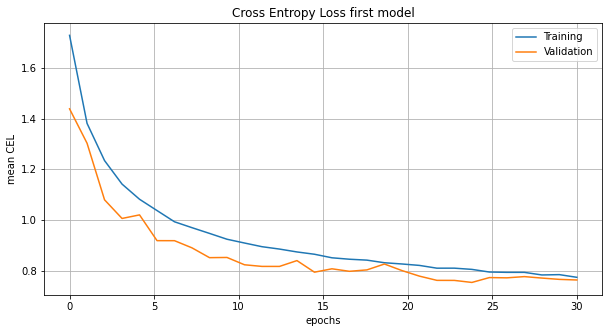

In [ ]:
# Plotting the results function
x = np.linspace(0, epochs, epochs)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, train_results, label='Training')
ax.plot(x, valid_results, label='Validation')
ax.set_xlabel('epochs')
ax.set_ylabel('mean CEL')
ax.set_title('Cross Entropy Loss first model')
ax.grid()

plt.legend()
plt.show()

## 8. Report the test set performance

In [ ]:
#Testing
mean_cel, total_accuracy, class_accuracy = testing(cnn, criterion, test_loader, train.classes, device)

In [ ]:
# Showing test results
from tabulate import tabulate
print("Mean Cross Entropy Loss from test is", mean_cel)

print('Total accuracy using the first model is %.2f %%' % total_accuracy)

print("\nAccuracy")

table = list()
table.append(["Total accuracy", total_accuracy])

[table.append([k, v]) for k,v in class_accuracy.items()]
print(tabulate(table, headers=["Class", "Accuracy in %"], tablefmt='orgtbl', floatfmt=".2f"))

Mean Cross Entropy Loss from test is 0.7630577220703466
Total accuracy using the first model is 73.81 %

Accuracy
| Class          |   Accuracy in % |
|----------------+-----------------|
| Total accuracy |           73.81 |
| airplane       |           81.82 |
| automobile     |           84.58 |
| bird           |           62.80 |
| cat            |           62.91 |
| deer           |           67.60 |
| dog            |           63.16 |
| frog           |           67.73 |
| horse          |           82.01 |
| ship           |           79.88 |
| truck          |           86.59 |


## 9. Second CNN model


### 9.1 Build the second CNN model with an additional convolution stage, training the dataset with the model. 

In [ ]:
# Class for the second CNN model
class CNN2(nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.6)
    self.fc1 = nn.Linear(128*2*2, 256)
    self.output = nn.Linear(256, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)
    return self.output(x)

In [ ]:
# Use the NN model with GPU
cnn2 = CNN2()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn2.to(device)
optimizer_2 = optim.SGD(cnn2.parameters(), lr=lr, momentum=decay_rate)


In [ ]:
train_results_2, valid_results_2 = training(epochs, cnn2, optimizer_2, criterion, train_loader, valid_loader, device)

In [ ]:
#Testing
mean_cel_2, total_accuracy_2, class_accuracy_2 = testing(cnn2, criterion, test_loader, train.classes, device)

### 9.2 Compare results from the first CNN model.

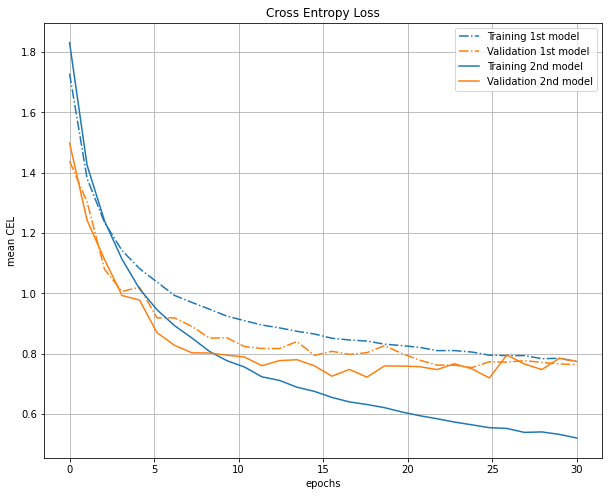

Mean Cross Entropy Loss from test on first model is 0.7630577220703466
Mean Cross Entropy Loss from test on second model is 0.7733145008643214
Total accuracy using the fist model is 73.81 %
Total accuracy using the second model is 75.24 %

Accuracy comparison in %
| Class          |   Model 1 |   Model2 |
|----------------+-----------+----------|
| Total accuracy |     73.81 |    75.24 |
| airplane       |     81.82 |    81.61 |
| automobile     |     84.58 |    86.07 |
| bird           |     62.80 |    61.80 |
| cat            |     62.91 |    69.93 |
| deer           |     67.60 |    70.50 |
| dog            |     63.16 |    65.54 |
| frog           |     67.73 |    75.40 |
| horse          |     82.01 |    82.63 |
| ship           |     79.88 |    82.06 |
| truck          |     86.59 |    77.44 |


In [ ]:
# Compare first and second model
x = np.linspace(0, epochs, epochs)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, train_results, color='#1f77b4', linestyle = 'dashdot', label='Training 1st model')
ax.plot(x, valid_results, color='#ff7f0e', linestyle = 'dashdot', label='Validation 1st model')
ax.plot(x, train_results_2, color='#1f77b4', label='Training 2nd model')
ax.plot(x, valid_results_2, color='#ff7f0e', label='Validation 2nd model')
ax.set_xlabel('epochs')
ax.set_ylabel('mean CEL')
ax.set_title('Cross Entropy Loss')
ax.grid()

plt.legend()
plt.show()

# Showing test results

results = ['Cross Entropy Loss']

print("Mean Cross Entropy Loss from test on first model is", mean_cel)

print("Mean Cross Entropy Loss from test on second model is", mean_cel_2)

print('Total accuracy using the fist model is %.2f %%' % total_accuracy)

print('Total accuracy using the second model is %.2f %%' % total_accuracy_2)

print("\nAccuracy comparison in %")

table2 = list()
table2.append(["Total accuracy", total_accuracy, total_accuracy_2])

[table2.append([c, a, b]) for c, a, b in zip(train.classes, class_accuracy.values(), class_accuracy_2.values())]
print(tabulate(table2, headers=["Class", "Model 1", "Model2"], tablefmt='orgtbl', floatfmt=".2f"))

### 9.3 Results
One more convolutional layer means the model finds more high-level features out of the features it found until the previous convolutional layer.

The second model having alittle higher accuracy than the first may be a just coincidence. I think that because mean CEL of second model is a little higher, the difference of accuracy is not that big, and when we look at the validation lines of both models in the plot, we see that they are on the same range and oscillating

In the plot we observe that in the training the second model performs better with lower mean Cross Entropy Loss. But in validtion and testing the difference is not that big. We also observe mean CEL of validation is reduced faster with second model than with first model. Also the learning is quicker in second model. Here we just used the model with additional layer with same hyper-parameters that's (somewhat) optimized for the first model. Maybe the second model could perform better if we fine-tuned the hyper-parameters.

